# terrabyte overview
<img src="./images/terrabyte.png" width="1100"/>

# Sentinel-1 Normalised Radar Backscatter (NRB)
<img src="./images/NRB1.png" width="1100"/>
<img src="./images/NRB2.png" width="1100"/>

# SAR processing basics
<img src="./images/sar_proc.png" width="1100"/>

# Prerequisites

This notebook is intended to be run in a Jupyter Lab session started via the OpenOnDemand portal of DLR's platform terrabyte.  
Execution is hence limited to persons eligible to creating an account on the platform.  

A conda environment can be created using the file `environment.yml`.

# STAC Data Exploration

https://stac.terrabyte.lrz.de/browser/?.language=en

https://stac.terrabyte.lrz.de/public/api

In [1]:
!hostname

hpdar03c02s02


In [2]:
from pystac_client import Client as pystacclient

In [3]:
catalog_url = 'https://stac.terrabyte.lrz.de/public/api'
catalog = pystacclient.open(catalog_url)

In [4]:
for collection in catalog.get_all_collections():
    print(collection.id)

cop-dem-glo-90
modis-13q1-061
viirs-09ga-001
modis-09ga-061
modis-13a3-061
modis-13a2-061
landsat-etm-c2-l2
modis-09gq-061
modis-10a1-061
landsat-tm-c2-l2
landsat-ot-c2-l2
sentinel-2-c0-l2a
sentinel-2-c0-l1c
cop-dem-glo-30
viirs-15a2h-001
viirs-13a1-001
sentinel-1-nrb
sentinel-2-c1-l2a
sentinel-1-slc
sentinel-1-grd


# Sentinel-1 NRB mosaic for Dec. 2022

In [5]:
import rioxarray
import numpy as np
from odc import stac as odc_stac

In [6]:
collection_s1 = 'sentinel-1-nrb'

resolution = 200
xsize = ysize = 1024
start = "2022-12-01T00:00:00Z"
stop = "2022-12-31T23:59:59Z"

dir_out = '.'
dir_tmp = './tmp'

In [7]:
results = catalog.search(collections=[collection_s1], datetime=[start, stop])
items = list(results.items())
print(f'found {len(items)} items')

found 943 items


In [8]:
cube = odc_stac.load(
    items,
    bands=['vv-g-lin'],
    resolution=resolution,
    resampling='average',
    groupby="solar_day",
    chunks={'x': xsize, 'y': ysize},
    nodata=-9999
)
cube = cube.chunk(chunks={'time':-1})
cube = cube.rio.write_crs(cube.coords['spatial_ref'].values)

vv = cube['vv-g-lin']
vv = vv.where(vv != vv.nodata)
vv

<xarray.DataArray 'vv-g-lin' (time: 25, y: 5050, x: 4308)>
dask.array<where, shape=(25, 5050, 4308), dtype=float32, chunksize=(25, 1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 6.2e+06 6.2e+06 6.2e+06 ... 5.19e+06 5.19e+06
  * x            (x) float64 1.741e+05 1.743e+05 ... 1.035e+06 1.036e+06
  * time         (time) datetime64[ns] 2022-12-01T05:49:48.500000 ... 2022-12...
    spatial_ref  int64 0
Attributes:
    nodata:   -9999

In [9]:
mean = vv.mean(dim='time', skipna=True, keep_attrs=True)
mean = 10 * np.log10(mean)
mean.rio.write_crs(vv.spatial_ref.attrs['crs_wkt'], inplace=True)
mean.rio.write_nodata(-9999, inplace=True)
mean

<xarray.DataArray 'vv-g-lin' (y: 5050, x: 4308)>
dask.array<mul, shape=(5050, 4308), dtype=float32, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 6.2e+06 6.2e+06 6.2e+06 ... 5.19e+06 5.19e+06
  * x            (x) float64 1.741e+05 1.743e+05 ... 1.035e+06 1.036e+06
    spatial_ref  int64 0
Attributes:
    _FillValue:  -9999.0

## Start of dask client for HPC computations

In [10]:
import os
import dask
from dask.distributed import Client

In [11]:
host = os.getenv("host")
jl_port = os.getenv("port")
dask_url = f"https://portal.terrabyte.lrz.de/node/{host}/{jl_port}/proxy/" + "{port}/status"
dask_address = "127.0.0.1:0"
dask_url

'https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/57019/proxy/{port}/status'

In [12]:
dask.config.set({'temporary_directory': dir_tmp,
                 'distributed.dashboard.link': dask_url})

In [13]:
client = Client(threads_per_worker=1, dashboard_address=dask_address)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/57019/proxy/45867/status,
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/57019/proxy/45867/status,Workers: 8
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:34409,Workers: 8
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/57019/proxy/45867/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:44141,Total threads: 1
Dashboard: https://portal.terrabyte.lrz.de/node/hpdar03c02s02.cos.lrz.de/57019/proxy/34829/status,Memory: 4.00 GiB
Nanny: tcp://127.0.0.1:41143,


In [14]:
!squeue -u di75wuy

             JOBID PARTITION     NAME     USER ST       TIME  NODES NODELIST(REASON)
           1210186 hpda2_jup sys/dash  di75wuy  R    1:08:38      1 hpdar03c02s02


In [15]:
fname_out = os.path.join(dir_out, 'germany_mean_2022-12.tif')
mean.rio.to_raster(raster_path=fname_out, driver='COG', 
                   overview_resampling='AVERAGE')

# Coastal Dynamics

In [20]:
import geogif

In [21]:
mgrs = '32UME'
resolution = 100
xsize = ysize = 256

In [22]:
query = {
    "mgrs:utm_zone": {'eq': mgrs[:2]},
    "mgrs:latitude_band": {'eq': mgrs[2]},
    "mgrs:grid_square": {'eq': mgrs[3:]}
}

results = catalog.search(collections=[collection_s1], datetime=[start, stop], query=query)
items = list(results.items())
print(f'found {len(items)} items')

found 13 items


In [23]:
cube = odc_stac.load(
    items,
    bands=['vv-g-log'],
    resolution=resolution,
    resampling='average',
    groupby="solar_day",
    chunks={'time': len(items), 'x': xsize, 'y': ysize}
)
cube = cube.rio.write_crs(cube.coords['spatial_ref'].values)

vv = cube['vv-g-log']
vv

<xarray.DataArray 'vv-g-log' (time: 13, y: 1098, x: 1099)>
dask.array<vv-g-log, shape=(13, 1098, 1099), dtype=float32, chunksize=(1, 256, 256), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 6e+06 6e+06 6e+06 ... 5.89e+06 5.89e+06 5.89e+06
  * x            (x) float64 4e+05 4e+05 4.002e+05 ... 5.096e+05 5.098e+05
  * time         (time) datetime64[ns] 2022-12-01T05:50:03 ... 2022-12-30T17:...
    spatial_ref  int64 0

In [24]:
vv_sub = vv.where((5935000 < vv.y) & (vv.y < 5973000)
                  & (394000 < vv.x) & (vv.x < 450000), drop=True)

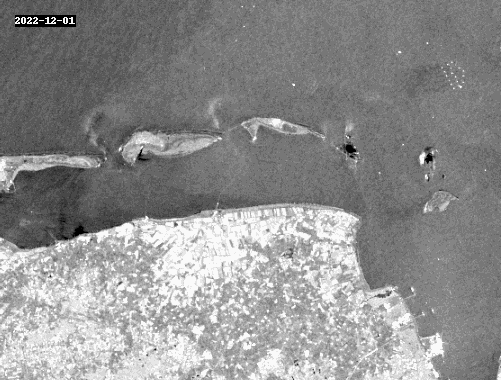

In [25]:
geogif.dgif(vv_sub, cmap='gray', fps=5).compute()

# Orbit Fusion: Local Resolution Weighting (LRW)

reference: https://doi.org/10.1109/tgrs.2021.3055562

In [26]:
from localtileserver import TileClient, get_leaflet_tile_layer
from ipyleaflet import Map, ScaleControl, FullScreenControl, SplitMapControl

In [27]:
mgrs = '32TPT'
resolution = 10
xsize = ysize = 1024

In [28]:
query = {
    "mgrs:utm_zone": {'eq': mgrs[:2]},
    "mgrs:latitude_band": {'eq': mgrs[2]},
    "mgrs:grid_square": {'eq': mgrs[3:]}
}

results = catalog.search(collections=[collection_s1], datetime=[start, stop], query=query)
items = list(results.items())
print(f'found {len(items)} items')

found 16 items


In [29]:
cube = odc_stac.load(
    items,
    bands=['vv-g-lin', 'contributing-area'],
    resolution=resolution,
    resampling='average',
    groupby="solar_day",
    chunks={'time': len(items), 'x': xsize, 'y': ysize}
)
cube = cube.rio.write_crs(cube.coords['spatial_ref'].values)

In [30]:
vv = cube['vv-g-lin']
lca = cube['contributing-area']

lca.rio.write_nodata(-9999, inplace=True)
lca = lca.where(lca != lca.nodata)

vv.rio.write_nodata(-9999, inplace=True)
vv = vv.where(vv != vv.nodata)

In [37]:
weights = (1 / lca).fillna(0)
lrw = vv.fillna(0).weighted(weights=weights).mean(dim='time', skipna=True, keep_attrs=True)
lrw = 10 * np.log10(lrw)
lrw.rio.write_nodata(-9999, inplace=True)
lrw.rio.write_crs(cube.spatial_ref.attrs['crs_wkt'], inplace=True)

<xarray.DataArray 'vv-g-lin' (y: 10980, x: 10980)>
dask.array<mul, shape=(10980, 10980), dtype=float32, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.3e+06 5.3e+06 5.3e+06 ... 5.19e+06 5.19e+06
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
    spatial_ref  int64 0
Attributes:
    _FillValue:  -9999.0

In [39]:
vv_mean = vv.mean(dim='time', skipna=True, keep_attrs=True)
vv_mean = 10 * np.log10(vv_mean)
vv_mean.rio.write_nodata(-9999, inplace=True)
vv_mean.rio.write_crs(cube.spatial_ref.attrs['crs_wkt'], inplace=True)

<xarray.DataArray 'vv-g-lin' (y: 10980, x: 10980)>
dask.array<mul, shape=(10980, 10980), dtype=float32, chunksize=(1024, 1024), chunktype=numpy.ndarray>
Coordinates:
  * y            (y) float64 5.3e+06 5.3e+06 5.3e+06 ... 5.19e+06 5.19e+06
  * x            (x) float64 6e+05 6e+05 6e+05 ... 7.098e+05 7.098e+05 7.098e+05
    spatial_ref  int64 0
Attributes:
    _FillValue:  -9999.0

In [38]:
fname_out_lrw = os.path.join(dir_out, 'germany_32tpt_lrw_2022-12.tif')
lrw.rio.to_raster(raster_path=fname_out_lrw, driver='COG', overview_resampling='AVERAGE', client=client)

In [40]:
fname_out_mean = os.path.join(dir_out, 'germany_32tpt_mean_2022-12.tif')
vv_mean.rio.to_raster(raster_path=fname_out_mean, driver='COG', overview_resampling='AVERAGE', client=client)

In [41]:
os.environ['LOCALTILESERVER_CLIENT_HOST'] = "https://portal.terrabyte.lrz.de/"
os.environ['LOCALTILESERVER_CLIENT_PREFIX'] = f"node/{host}/{jl_port}/proxy/" + "{port}"

In [42]:
l_client = TileClient(fname_out_mean)
r_client = TileClient(fname_out_lrw)

display = dict(vmin=-24, vmax=4, cmap='gray')

l = get_leaflet_tile_layer(l_client, **display)
r = get_leaflet_tile_layer(r_client, **display)

m = Map(center=l_client.center(), zoom=l_client.default_zoom)
control = SplitMapControl(left_layer=l, right_layer=r)
m.add_control(control)
m.add_control(ScaleControl(position='bottomleft'))
m.add_control(FullScreenControl())
m

Map(center=[47.339274685199115, 11.057366784208991], controls=(ZoomControl(options=['position', 'zoom_in_text'…

# vegetation indexes

In [43]:
mgrs = '32UPB'
resolution = 50
xsize = ysize = 1024
start = "2022-07-01T00:00:00Z"
stop = "2022-07-31T23:59:59Z"

In [44]:
query = {
    "mgrs:utm_zone": {'eq': mgrs[:2]},
    "mgrs:latitude_band": {'eq': mgrs[2]},
    "mgrs:grid_square": {'eq': mgrs[3:]}
}

results_s1 = catalog.search(collections=[collection_s1], datetime=[start, stop], query=query)
items_s1 = list(results_s1.items())
print(f'found {len(items_s1)} items')

found 13 items


In [45]:
collection_s2 = 'sentinel-2-c1-l2a'

query['eo:cloud_cover'] = {'lte': 30}
results_s2 = catalog.search(collections=[collection_s2], datetime=[start, stop], query=query)
items_s2 = list(results_s2.items())
print(f'found {len(items_s2)} items')

found 6 items


In [46]:
s1 = odc_stac.load(
    items_s1,
    bands=['vv-g-lin', 'vh-g-lin'],
    resolution=resolution,
    resampling='average',
    groupby="solar_day",
    chunks={'time': len(items_s1), 'x': xsize, 'y': ysize},
    nodata=-9999
)
s1 = s1.rio.write_crs(s1.coords['spatial_ref'].values)

vv = s1['vv-g-lin']
vv = vv.where(vv != vv.nodata).mean(dim='time', skipna=True)
vh = s1['vh-g-lin']
vh = vh.where(vh != vh.nodata).mean(dim='time', skipna=True)

In [47]:
s2 = odc_stac.load(
    items_s2,
    bands=['nir', 'red'],
    resolution=resolution,
    resampling='average',
    groupby="solar_day",
    chunks={'time': len(items_s2), 'x': xsize, 'y': ysize}
)
s2 = s2.rio.write_crs(s2.coords['spatial_ref'].values)

nir = s2['nir'].mean(dim='time')
red = s2['red'].mean(dim='time')

In [48]:
ndvi = (nir - red) / (nir + red)

In [49]:
rvi = (4 * vh) / (vv + vh)

In [50]:
fname_out_ndvi = os.path.join(dir_out, 'germany_32upb_ndvi_2022-07.tif')
ndvi.rio.to_raster(raster_path=fname_out_ndvi, driver='COG',
                   overview_resampling='AVERAGE', client=client)

In [51]:
fname_out_rvi = os.path.join(dir_out, 'germany_32upb_rvi_2022-07.tif')
rvi.rio.to_raster(raster_path=fname_out_rvi, driver='COG',
                  overview_resampling='AVERAGE', client=client)

In [52]:
l_client = TileClient(fname_out_ndvi)
r_client = TileClient(fname_out_rvi)

display = dict(vmin=0, vmax=1, cmap='Greens')

l = get_leaflet_tile_layer(l_client, **display)
r = get_leaflet_tile_layer(r_client, **display)

m = Map(center=l_client.center(), zoom=l_client.default_zoom)
control = SplitMapControl(left_layer=l, right_layer=r)
m.add_control(control)
m.add_control(ScaleControl(position='bottomleft'))
m.add_control(FullScreenControl())
m

Map(center=[50.93432298825847, 11.212870059071767], controls=(ZoomControl(options=['position', 'zoom_in_text',…